# Long Short Term Memory
Com Data-Set Aumentado.


In [2]:
#imports for split and load data
import numpy as np
import pandas as pd
import json

#imports for performance visualization
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random

#imports for the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, LeakyReLU, BatchNormalization, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import seaborn as sns



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load
all possible loads

In [4]:
#Deve atualizar a sua localização em relação ao ficheiro
mfcc40repetition = '/content/drive/MyDrive/files/features_mfcc40.json'

In [5]:
df = pd.read_json(mfcc40repetition)
df.columns

Index(['file', 'transformed', 'salience', 'fold', 'classID', 'mfcc40'], dtype='object')

## Funções Auxiliares para Split


In [6]:
#colunas que vamos remover
colunas_para_remover = ['file', 'salience',]
df = df.drop(colunas_para_remover, axis=1)
df.columns

Index(['transformed', 'fold', 'classID', 'mfcc40'], dtype='object')

In [7]:
print(len(df['mfcc40'][0]))

40


In [8]:
def contar_classes(df):
    """d
    Conta a quantidade de ocorrências de cada classe em um conjunto de dados.

    Parâmetros:
    - data: DataFrame Pandas contendo a coluna 'classID'.

    Retorna:
    - retorna o dicionario
    """
    contagem_classes = df['classID'].value_counts().to_dict()
    contagem_classes_ordenada = dict(sorted(contagem_classes.items()))
    return contagem_classes_ordenada

In [9]:
def get_info(df):
    """
    pandas methods for Basic Information from a df and call contar_classes
    """
    print(df)
    print(f"Contagem de classes no conjunto de teste: {contar_classes(df)}")

    print("Basic Information:")
    df.shape
    df.index
    df.columns
    df.info()
    df.count()

In [10]:
def adjust_dimensions(tensor, target_length):
    """
    321 é a nossa target length

    Adjusts the dimensions of a tensor by trimming.
    Em princípio, o padding não vai ser necessário.
    A função trata apenas uma dezena de instâncias que vêm em 13x324 em vez de 13x321.
    """
    for i in range(len(tensor)):
        for j in range(len(tensor[i])):
            if len(tensor[i][j]) > 321:
                tensor[i][j] = tensor[i][j][:321]

    return tensor

In [11]:
def to_3D_np(tensor):
    """"
    Transform to 3D np array
    only can be used if 3D
    """
    adjusted_tensor = adjust_dimensions(tensor,321) #321 é o legth estabelecido padrão da maioria
    np_tensor = np.array([np.array(seq) for seq in adjusted_tensor])
    return np_tensor

In [12]:
def to_1D_np(label):
    return np.array(label)

## Hold Out Split

>  *(posteriormente 10 fold cross)* **mas por enquanto vamos fazer só holdout com**:
>- (1,2,3,4,5,6,7,8) -> training set
>- (9) -> valid set
>- (8) -> test set

In [13]:
def split_data(representation, df):
    df = df[['fold',representation, 'classID']] #reduzir df

    # Dividir os dados em treinamento, validação e teste com base no fold isto tem que ser feito primeiro por que precisamos dos folds
    train_data = df[df['fold'].isin([1, 2, 3, 4, 5, 6, 7, 8])]
    validation_data = df[df['fold'] == 9]
    test_data = df[df['fold'] == 10]

    """
    descomentar comentário para visualizar estado
    """
    print()
    print(f"TEST SET:")
    get_info(test_data)
    print()
    print(f"VALIDATION SET:")
    get_info(validation_data)
    print()
    print(f"TRAIN SET:")
    get_info(train_data)


    # Separar as features e os labels
    X_train = train_data[representation].values
    y_train = train_data['classID'].values

    X_valid = validation_data[representation].values
    y_valid = validation_data['classID'].values

    X_test = test_data[representation].values
    y_test = test_data['classID'].values



    #passar para numpy:

    X_valid = to_3D_np(X_valid)
    X_test = to_3D_np(X_test)
    X_train = to_3D_np(X_train)

    y_train = to_1D_np(y_train)
    y_valid = to_1D_np(y_valid)
    y_test = to_1D_np(y_test)
    print("Splitted with success")


    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = split_data('mfcc40', df)


TEST SET:
       fold                                             mfcc40  classID
9137     10  [[0.0, 0.5478927493, 0.6362110972, 0.625538587...        3
9138     10  [[0.1871558875, 0.2124062628, 0.206416592, 0.2...        9
9139     10  [[0.0488475487, 0.032512832400000004, 0.064880...        0
9140     10  [[0.0687439442, 0.3061181605, 0.6982038617, 0....        4
9141     10  [[0.1078093797, 0.1048330739, 0.0972554311, 0....        8
...     ...                                                ...      ...
10141    10  [[0.0431582965, 0.031919945000000005, 0.038528...        8
10142    10  [[0.0, 0.055268406900000004, 0.047489263100000...        0
10143    10  [[0.033702936, 0.080786258, 0.1064587533, 0.09...        8
10144    10  [[0.1716143936, 0.31627538800000005, 0.2538642...        4
10145    10  [[0.2662045658, 0.1979651004, 0.24350675940000...        2

[1009 rows x 3 columns]
Contagem de classes no conjunto de teste: {0: 100, 1: 102, 2: 100, 3: 100, 4: 100, 5: 93, 6: 103, 7:

In [14]:
#check splitt
print("X_train", X_train.shape)
print("X_valid", X_valid.shape)
print("X_test", X_test.shape)
print()
print("y_train", y_train.shape)
print("y_valid",y_valid.shape)
print("y_test",y_test.shape)

X_train (8193, 40, 321)
X_valid (944, 40, 321)
X_test (1009, 40, 321)

y_train (8193,)
y_valid (944,)
y_test (1009,)


In [15]:
#check dimensions
for inst in X_train:
  for line in inst:
    if len(line) != 321:
      print(len(line))

## Build the LSTM


In [18]:
def build_lstm_model(input_shape, num_classes):

    model = Sequential()
    model.add(Bidirectional(LSTM(units=64,
               return_sequences=True,
               recurrent_regularizer=l2(0.01),
               recurrent_dropout=0.1),
               input_shape=input_shape)) #ALERT IS NOW BIDIRECTIONAL


    model.add(tf.keras.layers.Dropout(0.2))
    model.add(LeakyReLU(alpha=0.1))


    # Flatten the output and feed it to a Dense layer
    model.add(tf.keras.layers.Flatten())

    # Dense layer with 10 units (10 output classes)
    model.add(Dense(units=num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

### Trainning Process

In [19]:
# Input shape is the shape of your input data ((13, 26, ou 40), 321) for each sequence
input_shape = (X_train.shape[1], X_train.shape[2])

# Number of classes
num_classes = 10

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Build the model
lstm_model = build_lstm_model(input_shape, num_classes)

# Display the model summary
lstm_model.summary()

# Train the model
history = lstm_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=60, batch_size=96, callbacks=[early_stopping], shuffle = True) #

# Access the stopped_epoch attribute
stopped_epoch = early_stopping.stopped_epoch
print(f"Training stopped at {stopped_epoch} epochs.")
print("Model Evalueation:")
# Evaluate the model on the test set
test_loss, test_acc = lstm_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 40, 128)           197632    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 128)           0         
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                51210     
                                                                 
Total params: 248842 (972.04 KB)
Trainable params: 248842 (972.04 KB)
Non-trainable params: 0 (0.00 Byte)
______________

## Trainning evolution

In [20]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.subplots_adjust(hspace=0.5)
    plt.show()

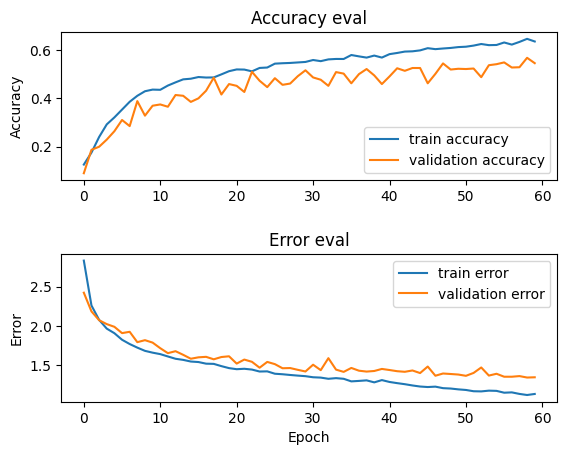

In [21]:
plot_history(history)

## Confusion Matrix

32/32 [==============================] - 1s 26ms/step


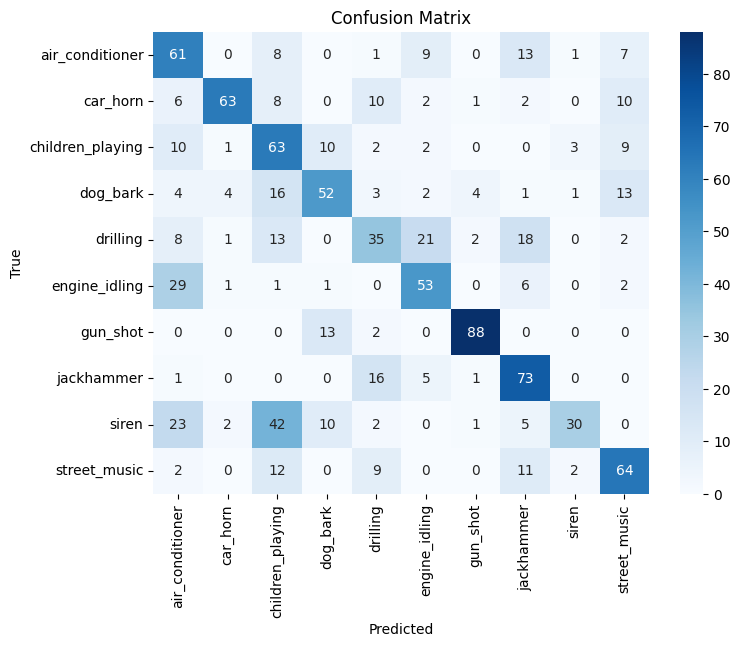


Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.61      0.50       100
           1       0.88      0.62      0.72       102
           2       0.39      0.63      0.48       100
           3       0.60      0.52      0.56       100
           4       0.44      0.35      0.39       100
           5       0.56      0.57      0.57        93
           6       0.91      0.85      0.88       103
           7       0.57      0.76      0.65        96
           8       0.81      0.26      0.39       115
           9       0.60      0.64      0.62       100

    accuracy                           0.58      1009
   macro avg       0.62      0.58      0.58      1009
weighted avg       0.62      0.58      0.57      1009



In [22]:
def _confusion_matrix(X_test,y_test_y,lstm_model):
  class_names = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
  y_pred = np.argmax(lstm_model.predict(X_test), axis=1)
  conf_matrix = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  # You can also print a classification report for more details
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

_confusion_matrix(X_test,y_test,lstm_model)

### "Classification Report" não nos é suficiente.
**Precisamos de ter uma noção de como o modelo está a prever mesmo quando o modelo não está a classificar bem. Os próximos dois gráficos ajudam-nos nessa tarefa:**
>1. O primeiro gráfico mostra uma distruibuição das Wrong Predicts do nosso modelo. Esta distribuição relaciona a probablilidade da previsão com que uma classe foi erradamente selecionada como a correct label.
>2. O Segundo gráfico aplica a mesma ideia mas para as instâncisas classificadas corretamente pela previsão.
>**Assim conseguimos ter uma noção do grau confiança com que foram feitas as previsões do modelo.**

Poderiamos dizer que esta representação se aproxima da ideia do f1_score

In [27]:
# Assuming lstm_model is your trained LSTM model
predictions = lstm_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
correct_labels = y_test  # Assuming y_test contains the true class labels

32/32 [==============================] - 1s 24ms/step


* **Previsões Erradas:**


In [29]:
class_names = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]

32/32 [==============================] - 1s 25ms/step


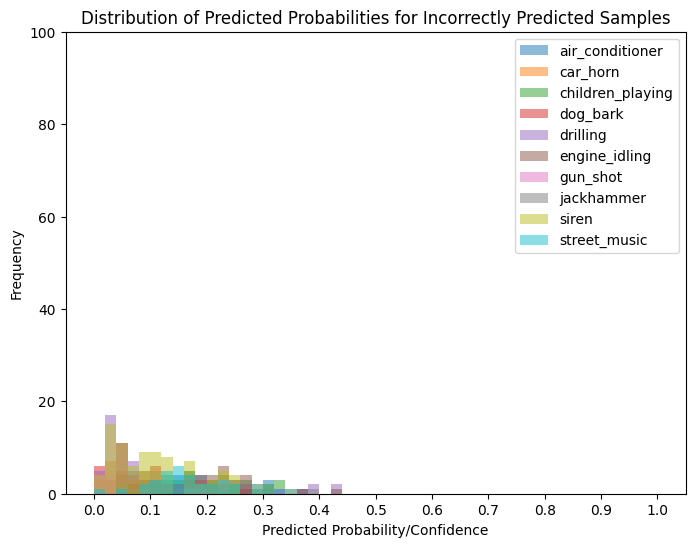

In [30]:
predictions = lstm_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
correct_labels = y_test  # Assuming y_test contains the true class labels

# Filter only incorrectly predicted samples
incorrectly_predicted_indices = np.where(predicted_labels != correct_labels)[0]
incorrect_predictions = predictions[incorrectly_predicted_indices]

plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    class_probs = incorrect_predictions[correct_labels[incorrectly_predicted_indices] == class_label, class_label]
    plt.hist(class_probs, bins=50, range=(0, 1), alpha=0.5, label=class_names[class_label])

plt.title('Distribution of Predicted Probabilities for Incorrectly Predicted Samples')
plt.xlabel('Predicted Probability/Confidence')
plt.ylabel('Frequency')
plt.ylim(0, 100)  # Set y-axis limits
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

* **Previsões Corretas:**


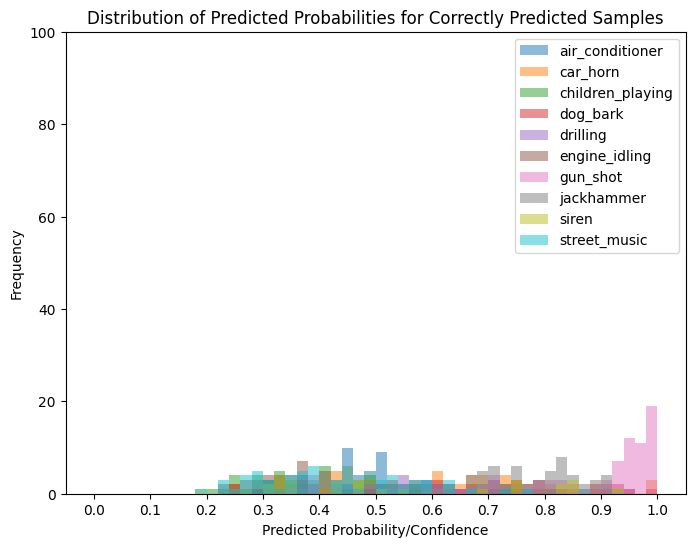

In [31]:
# Filter only correctly predicted samples
correctly_predicted_indices = np.where(predicted_labels == correct_labels)[0]
correct_predictions = predictions[correctly_predicted_indices]

# Plot histograms of predicted probabilities for correctly predicted samples
plt.figure(figsize=(8, 6))
for class_label in range(num_classes):
    class_probs = correct_predictions[correct_labels[correctly_predicted_indices] == class_label, class_label]
    plt.hist(class_probs, bins=50, range=(0, 1), alpha=0.5, label=class_names[class_label])

plt.title('Distribution of Predicted Probabilities for Correctly Predicted Samples')
plt.xlabel('Predicted Probability/Confidence')
plt.ylabel('Frequency')
plt.ylim(0, 100)  # Set y-axis limits
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()


# 10 fold cross validation


In [23]:
import random

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Vamos adaptar o split_data para kfoldcross validation.
Vamos fazer um loop de 10 e para cada um definimos um test fold diferente

In [25]:
def split_data_cross_validation(representation, df, test_fold):

    #dividir folds
    folds = [1,2,3,4,5,6,7,8,9,10]

    test_fold = test_fold                             #1º test fold é dado como argumento
    folds.remove(test_fold)
    validation_fold = random.choice(folds)            #2º train fold é um folder random do treino
    folds.remove(validation_fold)
    train_folds = folds                               #3º fold final resulta de todos os folds excepto o test e trainning


    #separar dataframe df de acordo com os folds resultantes
    test_data = df[df['fold'] == test_fold]
    train_data = df[df['fold'].isin(train_folds)]
    validation_data = df[df['fold'] == validation_fold]


    # shuffle WITHOU MIXING folds.
    test_data = test_data.sample(frac=1).reset_index(drop=True)
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    validation_data = validation_data.sample(frac=1).reset_index(drop=True)


    """
    descomentar comentário para visualizar estado

    print()
    print(f"TEST SET:")
    get_info(test_data)
    print()
    print(f"VALIDATION SET:")
    get_info(validation_data)
    print()
    print(f"TRAIN SET:")
    get_info(train_data)
    """

    # Separar as features e os labels
    X_train = train_data[representation].values
    y_train = train_data['classID'].values

    X_valid = validation_data[representation].values
    y_valid = validation_data['classID'].values

    X_test = test_data[representation].values
    y_test = test_data['classID'].values


    #passar para numpy:
    X_valid = to_3D_np(X_valid)
    X_test = to_3D_np(X_test)
    X_train = to_3D_np(X_train)

    y_train = to_1D_np(y_train)
    y_valid = to_1D_np(y_valid)
    y_test = to_1D_np(y_test)
    print("Splitted with success")


    return X_train, y_train, X_valid, y_valid, X_test, y_test

### 10-fold-cross-validation

__FOLD__1__


Splitted with success
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 40, 128)           197632    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 40, 128)           0         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 40, 128)           0         
                                                                 
 flatten_2 (Flatten)         (None, 5120)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                51210     
                                                                 
Total params: 248842 (972.04 KB)
Trainable params: 248842 (972.04 KB)
Non-trainable params: 0 (0.0

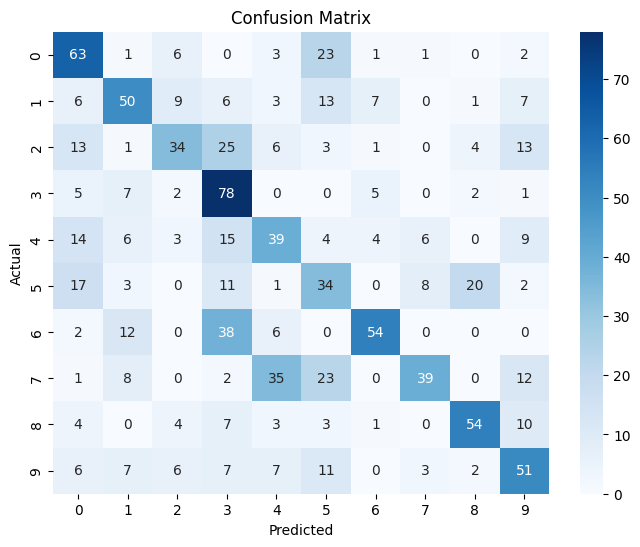

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       100
           1       0.53      0.49      0.51       102
           2       0.53      0.34      0.41       100
           3       0.41      0.78      0.54       100
           4       0.38      0.39      0.38       100
           5       0.30      0.35      0.32        96
           6       0.74      0.48      0.58       112
           7       0.68      0.33      0.44       120
           8       0.65      0.63      0.64        86
           9       0.48      0.51      0.49       100

    accuracy                           0.49      1016
   macro avg       0.52      0.49      0.49      1016
weighted avg       0.52      0.49      0.49      1016

__FOLD__2__


Splitted with success
Epoch 1/60
85/85 [==============================] - 22s 206ms/step - loss: 2.8267 - accuracy: 0.1383 - val_loss: 2.3995 - val_accuracy: 0.0872
Epoch 2/60
85/85 [==============================] - 17s 198ms/step - loss: 2.2374 - accuracy: 0.2075 - val_loss: 2.1498 - val_accuracy: 0.1298
Epoch 3/60
85/85 [==============================] - 17s 198ms/step - loss: 2.0494 - accuracy: 0.2647 - val_loss: 1.9931 - val_accuracy: 0.2716
Epoch 4/60
85/85 [==============================] - 17s 195ms/step - loss: 1.9296 - accuracy: 0.3072 - val_loss: 1.9539 - val_accuracy: 0.2854
Epoch 5/60
85/85 [==============================] - 17s 199ms/step - loss: 1.8257 - accuracy: 0.3632 - val_loss: 1.8086 - val_accuracy: 0.3845
Epoch 6/60
85/85 [==============================] - 17s 197ms/step - loss: 1.7697 - accuracy: 0.3842 - val_loss: 1.7576 - val_accuracy: 0.3905
Epoch 7/60
85/85 [==============================] - 17s 196ms/step - loss: 1.7100 - accuracy: 0.4009 - val_loss: 1.7519 

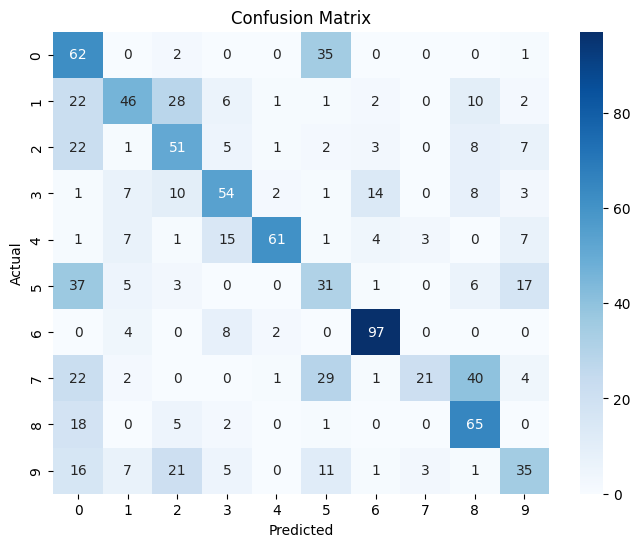

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.62      0.41       100
           1       0.58      0.39      0.47       118
           2       0.42      0.51      0.46       100
           3       0.57      0.54      0.55       100
           4       0.90      0.61      0.73       100
           5       0.28      0.31      0.29       100
           6       0.79      0.87      0.83       111
           7       0.78      0.17      0.29       120
           8       0.47      0.71      0.57        91
           9       0.46      0.35      0.40       100

    accuracy                           0.50      1040
   macro avg       0.56      0.51      0.50      1040
weighted avg       0.56      0.50      0.50      1040

__FOLD__3__


Splitted with success
Epoch 1/60
84/84 [==============================] - 22s 205ms/step - loss: 2.8240 - accuracy: 0.1323 - val_loss: 2.4330 - val_accuracy: 0.0666
Epoch 2/60
84/84 [==============================] - 16s 195ms/step - loss: 2.2310 - accuracy: 0.1915 - val_loss: 2.2285 - val_accuracy: 0.1656
Epoch 3/60
84/84 [==============================] - 16s 196ms/step - loss: 2.0487 - accuracy: 0.2536 - val_loss: 2.0879 - val_accuracy: 0.2255
Epoch 4/60
84/84 [==============================] - 17s 198ms/step - loss: 1.9422 - accuracy: 0.2994 - val_loss: 2.0059 - val_accuracy: 0.2940
Epoch 5/60
84/84 [==============================] - 17s 200ms/step - loss: 1.8652 - accuracy: 0.3402 - val_loss: 1.9011 - val_accuracy: 0.3482
Epoch 6/60
84/84 [==============================] - 17s 197ms/step - loss: 1.8109 - accuracy: 0.3590 - val_loss: 1.9005 - val_accuracy: 0.3197
Epoch 7/60
84/84 [==============================] - 16s 193ms/step - loss: 1.7665 - accuracy: 0.3875 - val_loss: 1.7659 

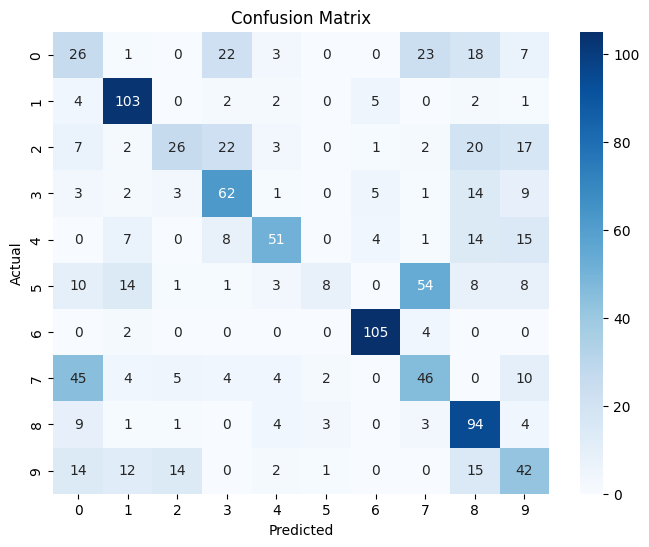

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.26      0.24       100
           1       0.70      0.87      0.77       119
           2       0.52      0.26      0.35       100
           3       0.51      0.62      0.56       100
           4       0.70      0.51      0.59       100
           5       0.57      0.07      0.13       107
           6       0.88      0.95      0.91       111
           7       0.34      0.38      0.36       120
           8       0.51      0.79      0.62       119
           9       0.37      0.42      0.39       100

    accuracy                           0.52      1076
   macro avg       0.53      0.51      0.49      1076
weighted avg       0.53      0.52      0.50      1076

__FOLD__4__


Splitted with success
Epoch 1/60
84/84 [==============================] - 22s 203ms/step - loss: 2.8455 - accuracy: 0.1143 - val_loss: 2.4134 - val_accuracy: 0.1010
Epoch 2/60
84/84 [==============================] - 16s 193ms/step - loss: 2.2585 - accuracy: 0.1842 - val_loss: 2.1686 - val_accuracy: 0.2154
Epoch 3/60
84/84 [==============================] - 16s 192ms/step - loss: 2.0512 - accuracy: 0.2589 - val_loss: 2.0298 - val_accuracy: 0.2894
Epoch 4/60
84/84 [==============================] - 16s 191ms/step - loss: 1.8999 - accuracy: 0.3232 - val_loss: 1.9374 - val_accuracy: 0.3337
Epoch 5/60
84/84 [==============================] - 16s 192ms/step - loss: 1.8064 - accuracy: 0.3706 - val_loss: 1.8602 - val_accuracy: 0.4183
Epoch 6/60
84/84 [==============================] - 16s 196ms/step - loss: 1.7483 - accuracy: 0.3841 - val_loss: 1.8038 - val_accuracy: 0.4029
Epoch 7/60
84/84 [==============================] - 17s 198ms/step - loss: 1.7081 - accuracy: 0.4046 - val_loss: 1.9070 

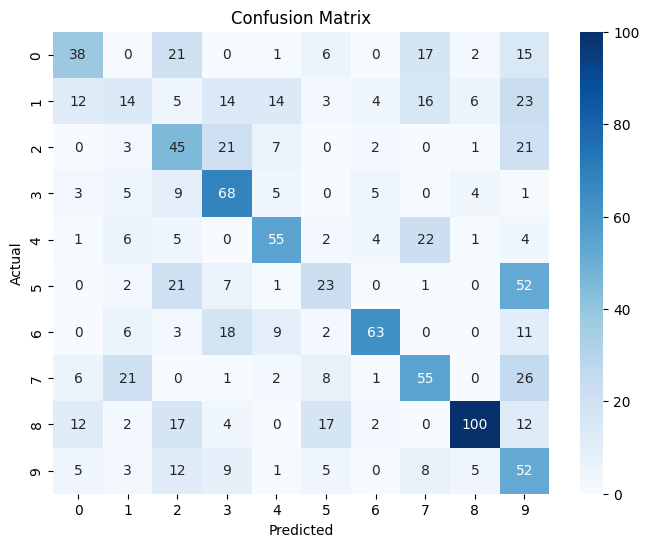

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       100
           1       0.23      0.13      0.16       111
           2       0.33      0.45      0.38       100
           3       0.48      0.68      0.56       100
           4       0.58      0.55      0.56       100
           5       0.35      0.21      0.27       107
           6       0.78      0.56      0.65       112
           7       0.46      0.46      0.46       120
           8       0.84      0.60      0.70       166
           9       0.24      0.52      0.33       100

    accuracy                           0.46      1116
   macro avg       0.48      0.45      0.45      1116
weighted avg       0.50      0.46      0.46      1116

__FOLD__5__


Splitted with success
Epoch 1/60
85/85 [==============================] - 22s 202ms/step - loss: 2.8240 - accuracy: 0.1222 - val_loss: 2.3813 - val_accuracy: 0.1613
Epoch 2/60
85/85 [==============================] - 17s 195ms/step - loss: 2.2323 - accuracy: 0.1836 - val_loss: 2.1119 - val_accuracy: 0.2393
Epoch 3/60
85/85 [==============================] - 17s 198ms/step - loss: 2.0531 - accuracy: 0.2500 - val_loss: 1.9844 - val_accuracy: 0.2970
Epoch 4/60
85/85 [==============================] - 17s 197ms/step - loss: 1.9553 - accuracy: 0.2927 - val_loss: 1.8572 - val_accuracy: 0.3472
Epoch 5/60
85/85 [==============================] - 17s 199ms/step - loss: 1.8659 - accuracy: 0.3320 - val_loss: 1.7653 - val_accuracy: 0.3462
Epoch 6/60
85/85 [==============================] - 17s 197ms/step - loss: 1.8155 - accuracy: 0.3565 - val_loss: 1.7438 - val_accuracy: 0.3269
Epoch 7/60
85/85 [==============================] - 17s 198ms/step - loss: 1.7753 - accuracy: 0.3833 - val_loss: 1.7283 

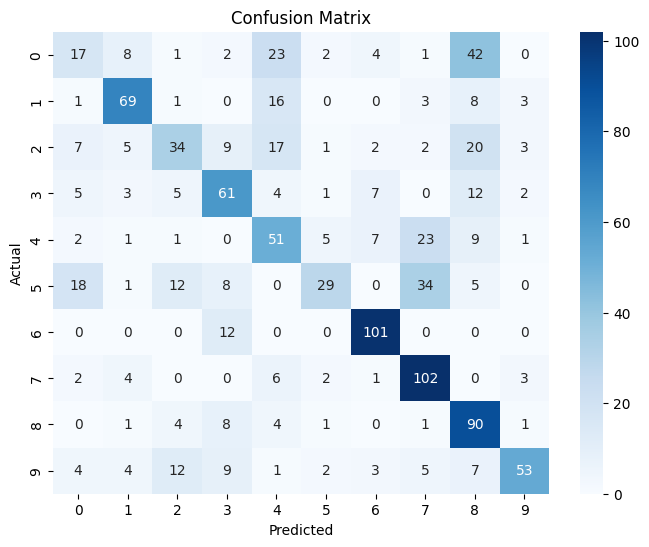

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.17      0.22       100
           1       0.72      0.68      0.70       101
           2       0.49      0.34      0.40       100
           3       0.56      0.61      0.58       100
           4       0.42      0.51      0.46       100
           5       0.67      0.27      0.39       107
           6       0.81      0.89      0.85       113
           7       0.60      0.85      0.70       120
           8       0.47      0.82      0.59       110
           9       0.80      0.53      0.64       100

    accuracy                           0.58      1051
   macro avg       0.58      0.57      0.55      1051
weighted avg       0.59      0.58      0.56      1051

__FOLD__6__


Splitted with success
Epoch 1/60
85/85 [==============================] - 22s 200ms/step - loss: 2.8405 - accuracy: 0.1245 - val_loss: 2.3971 - val_accuracy: 0.1506
Epoch 2/60
85/85 [==============================] - 16s 193ms/step - loss: 2.2540 - accuracy: 0.1808 - val_loss: 2.1347 - val_accuracy: 0.1824
Epoch 3/60
85/85 [==============================] - 17s 195ms/step - loss: 2.0835 - accuracy: 0.2450 - val_loss: 2.0201 - val_accuracy: 0.3003
Epoch 4/60
85/85 [==============================] - 17s 199ms/step - loss: 1.9543 - accuracy: 0.3065 - val_loss: 1.8914 - val_accuracy: 0.3964
Epoch 5/60
85/85 [==============================] - 16s 193ms/step - loss: 1.8596 - accuracy: 0.3380 - val_loss: 1.8330 - val_accuracy: 0.3627
Epoch 6/60
85/85 [==============================] - 17s 194ms/step - loss: 1.7899 - accuracy: 0.3820 - val_loss: 1.7654 - val_accuracy: 0.4073
Epoch 7/60
85/85 [==============================] - 16s 193ms/step - loss: 1.7307 - accuracy: 0.4053 - val_loss: 1.7444 

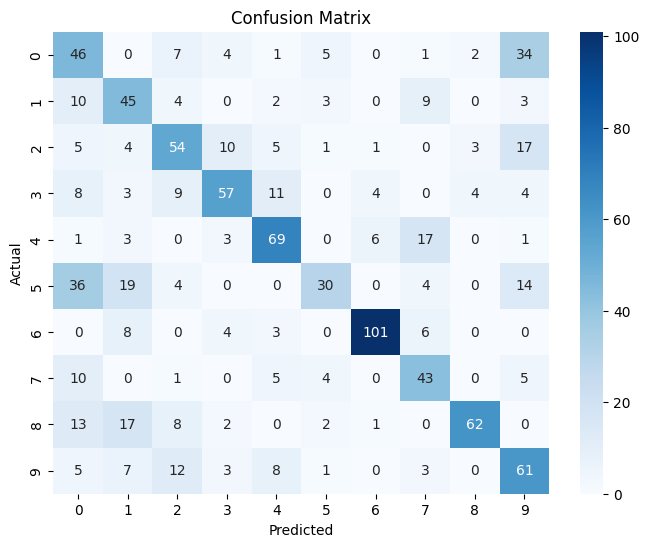

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.46      0.39       100
           1       0.42      0.59      0.49        76
           2       0.55      0.54      0.54       100
           3       0.69      0.57      0.62       100
           4       0.66      0.69      0.68       100
           5       0.65      0.28      0.39       107
           6       0.89      0.83      0.86       122
           7       0.52      0.63      0.57        68
           8       0.87      0.59      0.70       105
           9       0.44      0.61      0.51       100

    accuracy                           0.58       978
   macro avg       0.60      0.58      0.58       978
weighted avg       0.62      0.58      0.58       978

__FOLD__7__


Splitted with success
Epoch 1/60
86/86 [==============================] - 22s 204ms/step - loss: 2.8178 - accuracy: 0.1283 - val_loss: 2.4293 - val_accuracy: 0.1600
Epoch 2/60
86/86 [==============================] - 17s 197ms/step - loss: 2.2517 - accuracy: 0.1799 - val_loss: 2.1727 - val_accuracy: 0.2489
Epoch 3/60
86/86 [==============================] - 17s 199ms/step - loss: 2.0639 - accuracy: 0.2559 - val_loss: 2.0638 - val_accuracy: 0.2839
Epoch 4/60
86/86 [==============================] - 17s 200ms/step - loss: 1.9375 - accuracy: 0.3150 - val_loss: 1.9578 - val_accuracy: 0.3189
Epoch 5/60
86/86 [==============================] - 17s 197ms/step - loss: 1.8433 - accuracy: 0.3623 - val_loss: 1.8921 - val_accuracy: 0.3093
Epoch 6/60
86/86 [==============================] - 17s 197ms/step - loss: 1.7833 - accuracy: 0.3763 - val_loss: 1.8388 - val_accuracy: 0.3220
Epoch 7/60
86/86 [==============================] - 17s 199ms/step - loss: 1.7459 - accuracy: 0.3997 - val_loss: 1.8094 

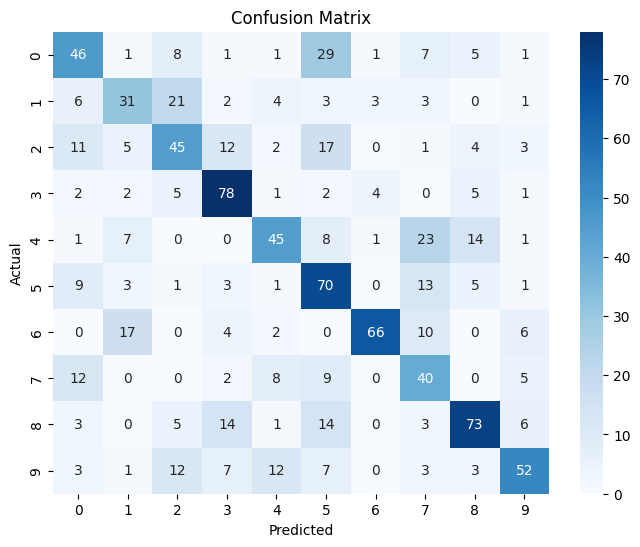

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.46      0.48       100
           1       0.46      0.42      0.44        74
           2       0.46      0.45      0.46       100
           3       0.63      0.78      0.70       100
           4       0.58      0.45      0.51       100
           5       0.44      0.66      0.53       106
           6       0.88      0.63      0.73       105
           7       0.39      0.53      0.45        76
           8       0.67      0.61      0.64       119
           9       0.68      0.52      0.59       100

    accuracy                           0.56       980
   macro avg       0.57      0.55      0.55       980
weighted avg       0.58      0.56      0.56       980

__FOLD__8__


Splitted with success
Epoch 1/60
87/87 [==============================] - 25s 202ms/step - loss: 2.8051 - accuracy: 0.1343 - val_loss: 2.3904 - val_accuracy: 0.1282
Epoch 2/60
87/87 [==============================] - 18s 202ms/step - loss: 2.2217 - accuracy: 0.1963 - val_loss: 2.1620 - val_accuracy: 0.2267
Epoch 3/60
87/87 [==============================] - 17s 199ms/step - loss: 2.0568 - accuracy: 0.2395 - val_loss: 2.0829 - val_accuracy: 0.2521
Epoch 4/60
87/87 [==============================] - 17s 201ms/step - loss: 1.9437 - accuracy: 0.2985 - val_loss: 1.9846 - val_accuracy: 0.2701
Epoch 5/60
87/87 [==============================] - 17s 197ms/step - loss: 1.8797 - accuracy: 0.3338 - val_loss: 1.9357 - val_accuracy: 0.2807
Epoch 6/60
87/87 [==============================] - 17s 197ms/step - loss: 1.8167 - accuracy: 0.3574 - val_loss: 1.8424 - val_accuracy: 0.2934
Epoch 7/60
87/87 [==============================] - 18s 201ms/step - loss: 1.7625 - accuracy: 0.3766 - val_loss: 1.8497 

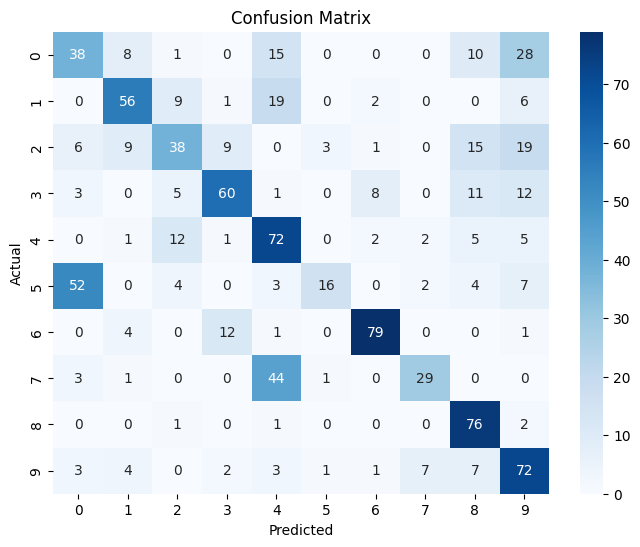

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.38      0.37       100
           1       0.67      0.60      0.64        93
           2       0.54      0.38      0.45       100
           3       0.71      0.60      0.65       100
           4       0.45      0.72      0.56       100
           5       0.76      0.18      0.29        88
           6       0.85      0.81      0.83        97
           7       0.72      0.37      0.49        78
           8       0.59      0.95      0.73        80
           9       0.47      0.72      0.57       100

    accuracy                           0.57       936
   macro avg       0.61      0.57      0.56       936
weighted avg       0.61      0.57      0.56       936

__FOLD__9__


Splitted with success
Epoch 1/60
85/85 [==============================] - 23s 212ms/step - loss: 2.8151 - accuracy: 0.1280 - val_loss: 2.3888 - val_accuracy: 0.1543
Epoch 2/60
85/85 [==============================] - 17s 205ms/step - loss: 2.2175 - accuracy: 0.2039 - val_loss: 2.1679 - val_accuracy: 0.1673
Epoch 3/60
85/85 [==============================] - 17s 200ms/step - loss: 2.0208 - accuracy: 0.2816 - val_loss: 2.0282 - val_accuracy: 0.2574
Epoch 4/60
85/85 [==============================] - 17s 202ms/step - loss: 1.9212 - accuracy: 0.3177 - val_loss: 1.9334 - val_accuracy: 0.2807
Epoch 5/60
85/85 [==============================] - 17s 201ms/step - loss: 1.8261 - accuracy: 0.3640 - val_loss: 1.8583 - val_accuracy: 0.3569
Epoch 6/60
85/85 [==============================] - 17s 201ms/step - loss: 1.7732 - accuracy: 0.3916 - val_loss: 1.8534 - val_accuracy: 0.2993
Epoch 7/60
85/85 [==============================] - 17s 197ms/step - loss: 1.7528 - accuracy: 0.3952 - val_loss: 1.8446 

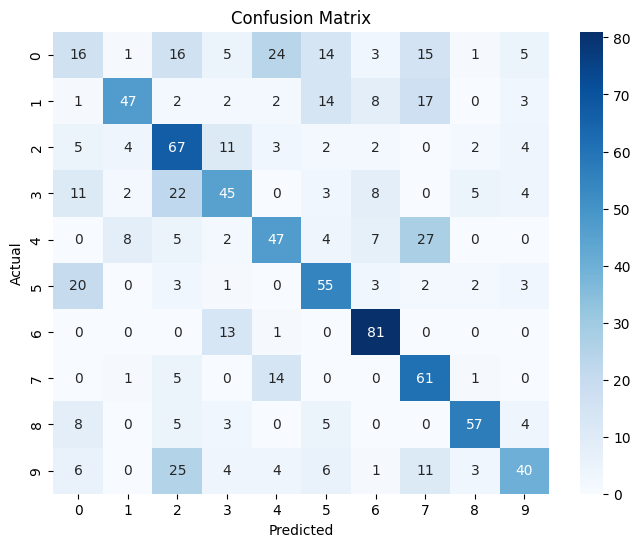

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.16      0.19       100
           1       0.75      0.49      0.59        96
           2       0.45      0.67      0.54       100
           3       0.52      0.45      0.48       100
           4       0.49      0.47      0.48       100
           5       0.53      0.62      0.57        89
           6       0.72      0.85      0.78        95
           7       0.46      0.74      0.57        82
           8       0.80      0.70      0.75        82
           9       0.63      0.40      0.49       100

    accuracy                           0.55       944
   macro avg       0.56      0.55      0.54       944
weighted avg       0.56      0.55      0.54       944

__FOLD__10__


Splitted with success
Epoch 1/60
86/86 [==============================] - 23s 214ms/step - loss: 2.8220 - accuracy: 0.1257 - val_loss: 2.3938 - val_accuracy: 0.1357
Epoch 2/60
86/86 [==============================] - 18s 204ms/step - loss: 2.2532 - accuracy: 0.1814 - val_loss: 2.1303 - val_accuracy: 0.1998
Epoch 3/60
86/86 [==============================] - 18s 204ms/step - loss: 2.0833 - accuracy: 0.2467 - val_loss: 1.9996 - val_accuracy: 0.2393
Epoch 4/60
86/86 [==============================] - 18s 206ms/step - loss: 1.9706 - accuracy: 0.2963 - val_loss: 1.8488 - val_accuracy: 0.3365
Epoch 5/60
86/86 [==============================] - 18s 212ms/step - loss: 1.8680 - accuracy: 0.3408 - val_loss: 1.7271 - val_accuracy: 0.3846
Epoch 6/60
86/86 [==============================] - 18s 205ms/step - loss: 1.8166 - accuracy: 0.3590 - val_loss: 1.7302 - val_accuracy: 0.3697
Epoch 7/60
86/86 [==============================] - 18s 204ms/step - loss: 1.7605 - accuracy: 0.3878 - val_loss: 1.6142 

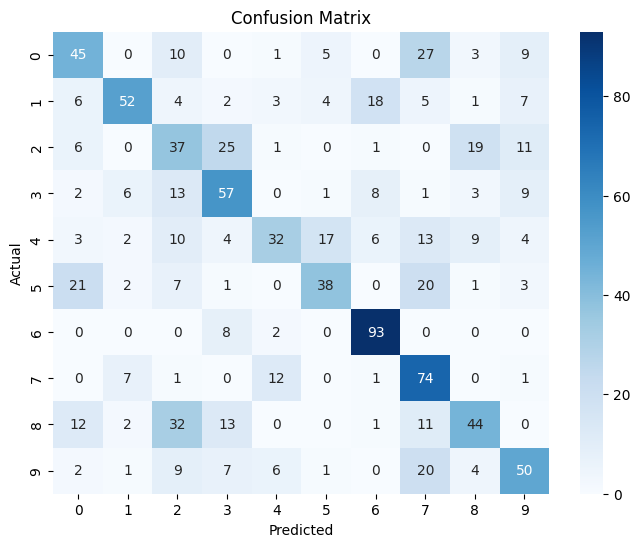

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.45      0.46       100
           1       0.72      0.51      0.60       102
           2       0.30      0.37      0.33       100
           3       0.49      0.57      0.53       100
           4       0.56      0.32      0.41       100
           5       0.58      0.41      0.48        93
           6       0.73      0.90      0.81       103
           7       0.43      0.77      0.55        96
           8       0.52      0.38      0.44       115
           9       0.53      0.50      0.52       100

    accuracy                           0.52      1009
   macro avg       0.53      0.52      0.51      1009
weighted avg       0.53      0.52      0.51      1009

__FINAL_EVALUATION__
Average Test Accuracy: 0.5326054006814956
Average Classification Report:
{'precision': 0.554521131151118, 'recall': 0.5312739643274037, 'f1-score': 0.5223959807349527}


In [26]:
def ten_fold_cross_validation(representation, df):
    df = df[['fold', representation, 'classID']]
    num_classes = 10
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for current_test_fold in range(1, 11):
        print(f"__FOLD__{current_test_fold}__")

        X_train, y_train, X_valid, y_valid, X_test, y_test = split_data_cross_validation('mfcc40', df, current_test_fold)
        input_shape = (X_train.shape[1], X_train.shape[2])
        lstm_model = build_lstm_model(input_shape, num_classes)

        if current_test_fold == 1:
            lstm_model.summary()

        history = lstm_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=60, batch_size=96, callbacks=[early_stopping], shuffle=True)
        stopped_epoch = early_stopping.stopped_epoch
        print(f"Training stopped at {stopped_epoch} epochs.")
        print("Model Evaluation:")
        test_loss, test_acc = lstm_model.evaluate(X_test, y_test)
        print(f'Test accuracy: {test_acc}')


        y_pred = lstm_model.predict(X_test)

        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = y_test

        # Print confusion matrix
        cm = confusion_matrix(y_test_labels, y_pred_labels)
        # Plot confusion matrix
        plot_confusion_matrix(y_test_labels, y_pred_labels, classes=[str(i) for i in range(num_classes)])



        # Calculate and print classification report
        report = classification_report(y_test_labels, y_pred_labels)
        print("Classification Report:")
        print(report)

        accuracy_list.append(test_acc)

        # Parse the classification report string into a dictionary
        report_dict = classification_report(y_test_labels, y_pred_labels, output_dict=True)
        precision_list.append(report_dict['macro avg']['precision'])
        recall_list.append(report_dict['macro avg']['recall'])
        f1_list.append(report_dict['macro avg']['f1-score'])

    print("__FINAL_EVALUATION__")
    # Calculate and print the average accuracy
    average_accuracy = np.mean(accuracy_list)
    print(f'Average Test Accuracy: {average_accuracy}')

    # Calculate and print the average classification report
    average_precision = np.mean(precision_list)
    average_recall = np.mean(recall_list)
    average_f1 = np.mean(f1_list)

    average_classification_report = {
        'precision': average_precision,
        'recall': average_recall,
        'f1-score': average_f1
    }

    print("Average Classification Report:")
    print(average_classification_report)

ten_fold_cross_validation("mfcc40", df)


## Comparar o mesmo LSTM model para o dataset normal e dataset aumentado

### Sem data augmentation:

- Average Test Accuracy: 0.49774750173091886
- Average Classification Report:
{'precision': 0.5455068243358525, 'recall': 0.5028310791127983, 'f1-score': 0.4973655129709848}
---
### Com data augmentation:

- Average Test Accuracy: 0.5326054006814956
- Average Classification Report:
{'precision': 0.554521131151118, 'recall': 0.5312739643274037, 'f1-score': 0.5223959807349527}



#### **Observações/Conclusões**

Ainda que a accuracy de ambos os modelos seja baixa, é possivel verificar que com um dataset maior e mais diversificado, o modelo é capaz de classificar melhor e de forma mais generalizada. Isto reforça a ideia de que, independentemente do método usado para classificação, a quantidade e variedade de dados será sempre o ponto crucial para a construção de bom modelos.


#### **O que podemos deduzir**

É dificil comparar a CNN e a LSTM implementadas, visto que os processos de experimentação para chegar aos modelos mais ótimos foi diferente e, para além disso, nada nos garante que o modelo ótimo foi de facto alcançado. Contudo, avaliando apenas pelos resultados obtidos, observamos que a CNN aparenta ter melhor performance para este problema com MFCCs. 

As LSTMs são modelos próprios para lidar com séries temporais, como é o caso do som, porém como o som é representado pelos MFCCs, o aspeto sequencial e temporal perde valor e por isso o LSTM deixa de ser vantajoso, dado que estamos a tratar os sons como imagens.